In [1]:
import os
import h5py
from itertools import product

import numpy
from numpy import array, arange, zeros, ones, sqrt, exp, log, log10, where, diff, argmax, \
    concatenate, nan, isnan, nanmean, unwrap, angle, outer, cumsum, pad, flip, diag, mean, identity
from numpy.linalg import inv
from numpy.random import randn

from scipy.linalg import block_diag, kron, norm, sqrtm
from scipy.signal import argrelmax
from scipy.constants import pi, c
from scipy.io import loadmat
import scipy.sparse

from utils.gpst import gpst2dt, dt2gpst
from utils.scintillation import compute_fractional_moments, compute_decorrelation_time
from utils.detect import estimate_sparse_dz_hat, consolidate_times, detect_slips
from utils.estimate import partition_and_compute_dz_marginals
from utils.cycle_slip_model import KERNEL_FUNCTIONS, create_B, create_Qy, create_Xi
k_Matern = KERNEL_FUNCTIONS['matern']

import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
plt.rcParams.update({'font.size': 18})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

In [5]:
from numpy import cross

In [4]:
# Define GPS carrier frequencies
fL1 = 1.57542e9
fL2 = 1.2276e9
fL5 = 1.17645e9

sig_ids = ['L1', 'L2', 'L5']
freqs = array([fL1, fL2, fL5])
wavelengths = 299792458 / freqs
kappa_u = 40.308e16
beta = kappa_u / freqs**2
Nf = len(freqs)

C_GIF = cross(beta, ones(Nf))
C_IF = cross(ones(Nf), C_GIF)
C_TEC = cross(beta, C_GIF)

# Load triple-frequency data
data = loadmat('/media/share/brianbw/data/hong-kong_20131005_G24_meta-measurements_updated.mat')

time_full = data['time'].squeeze()
start_of_day_dt = gpst2dt(time_full[0]).replace(hour=0, minute=0, second=0, microsecond=0)
start_of_day_gpst = dt2gpst(start_of_day_dt)
time_full -= start_of_day_gpst

rate = 100
dt_full = 1 / rate

adr_full = numpy.stack([data[sig_id]['adr'][0][0].squeeze() for sig_id in sig_ids])
cn0_full = numpy.stack([data[sig_id]['cn0'][0][0].squeeze() for sig_id in sig_ids])
z_true_full = numpy.stack([data[sig_id]['bias'][0][0].squeeze() for sig_id in sig_ids])
cn0_dB_full = 10 * log10(cn0_full.clip(min=1))

IF_raw_full = (adr_full * C_IF[:, None]).sum(axis=0)
TEC_raw_full = (adr_full * C_TEC[:, None]).sum(axis=0)
GIF_raw_full = (adr_full * C_GIF[:, None]).sum(axis=0)

In [5]:
# window = 60  # seconds
# time_10s = time_full[::window * rate]
# Nw = window * rate
# _cn0 = cn0_full.reshape((Nf, -1, Nw))
# S4 = sqrt((numpy.mean(_cn0**2, axis=2) - numpy.mean(_cn0, axis=2)**2) / numpy.mean(_cn0, axis=2)**2)
# tau = numpy.stack([compute_decorrelation_time(cn0_full[k, :].reshape((-1, window * rate)), dt_full) for k in range(Nf)])
# U = map_to_U(S4[0, :].clip(0, 1))
# roveff = array([map_to_roveff(U, tau[k, :]) for k in range(Nf)])

# tau[:, time_10s < 43400] = nan
# tau[:, time_10s > 45700] = nan

In [6]:
# window2 = 44900, 45400

In [7]:
# for window in [window1, window2]:
#     i0, i1 = numpy.searchsorted(time_10s, window)
#     window_S4 = numpy.max(S4[0, i0:i1])
#     window_tau = numpy.max(tau[0, i0:i1])
#     print('{0:3.3f}, {1:3.3f}'.format(window_S4, window_tau))

0.856, 0.620
0.707, 0.820


In [9]:
# Window 1
window1 = 43440, 43940
g_amp = .001
g_scale = 60
i_amp = .8
i_scale = 8
sigma_n = .4
qbias = 2
lambda0 = 20
t0, t1 = window1
window_label = '1'

In [10]:
# Obtain just the data for the window
skip = 5
i0, i1 = numpy.searchsorted(time_full, [t0, t1])

time = time_full[i0:i1:skip]
adr = adr_full[:, i0:i1:skip]
z_true = z_true_full[:, i0:i1:skip]
cn0 = cn0_full[:, i0:i1:skip]
cn0_dB = cn0_dB_full[:, i0:i1:skip]

dt = dt_full * skip
Nt = len(time)

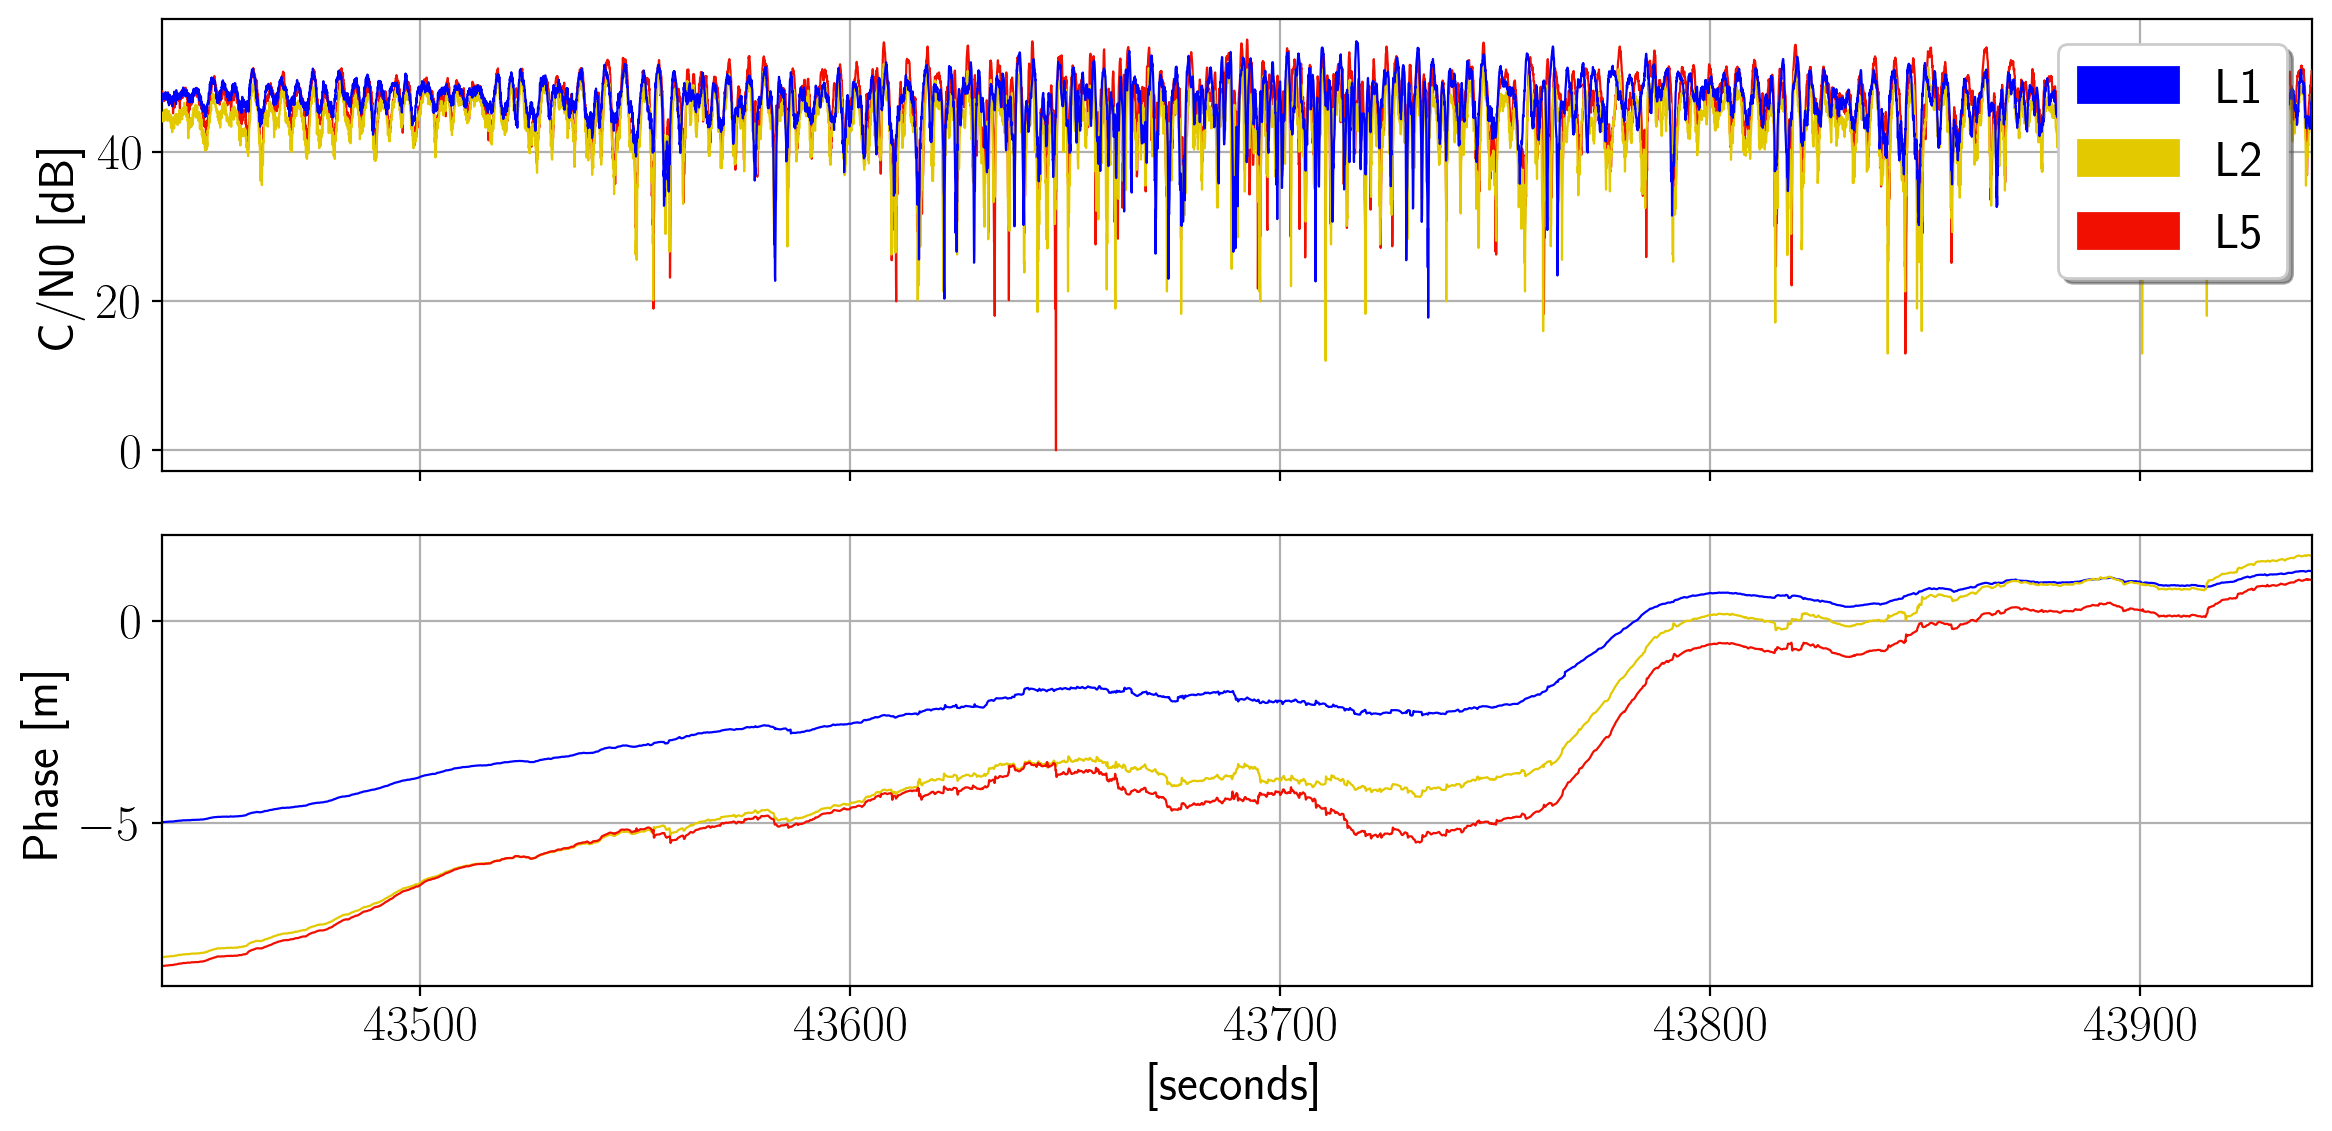

In [11]:
fig = plt.figure(figsize=(12, 6), dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for k, sig_id in enumerate(sig_ids):
    ax1.plot(time, cn0_dB[k, :], color=COLORS[sig_id], linewidth=.8, zorder=5 - k)
    ax2.plot(time, adr[k, :], color=COLORS[sig_id], linewidth=.8)
for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim(time[[0, -1]])
ax1.set_ylabel('C/N0 [dB]')
ax1.set_xticklabels([])
ax2.set_ylabel('Phase [m]')
ax2.set_xlabel('[seconds]')
handles = [plt.Rectangle((nan, nan), 1, 1, color=COLORS[sig_id]) for sig_id in sig_ids]
labels = sig_ids
ax1.legend(handles, labels, loc=1, shadow=True)
plt.tight_layout()
plt.show()

In [12]:
# Create cycle slip estimation model
t = time - time[0]
qg = k_Matern(t, g_amp, g_scale)
qi = k_Matern(t, i_amp, i_scale)
qeps = (sigma_n * kron(c / freqs[None, :], ones((1, Nt)))).squeeze()**2

Ni = 30  # number of L1 minimization iterations

z_skip = 4
time_z = time[z_skip::z_skip]
Nz = len(time_z)
dz_est = zeros((Ni, Nf, Nz))

zero_threshold = 1e-9
lambd = lambda0 * ones((Nf, Nz))
norm_type = 0  # 0, 1, 2: 1 sep, 1 group, 2 group

B = create_B(freqs, time, time_z)
Qy = create_Qy(freqs, qg, qi, qeps, qbias)

y = adr - adr[:, 0:1]
Qyinvy, _ = scipy.sparse.linalg.cg(Qy, y.flatten())
BTQyinvy = B.T @ Qyinvy

In [12]:
# Estimate sparse float cycle slip amplitudes
dz_hat0 = numpy.diff(y[:, ::z_skip] * freqs[:, None] / c, axis=1)
dz_hat = estimate_sparse_dz_hat(y, freqs, time, time_z, Qy, Ni=30, dz_hat0=dz_hat0,
        lambda0=lambda0, zero_threshold=zero_threshold, norm_type=norm_type)

  30 /  30   0.05009

In [13]:
# Detect slip occurrences
time_det = detect_slips(time_z, dz_hat, detection_threshold=1e-2, consolidate_window=.4)
dz_indices = numpy.searchsorted(time, time_det)
Nd = len(time_det)
print('{0} slips detected.'.format(Nd))

62


In [14]:
# Compute `inv(Qy) * y` for reduced model
Qyinvy, _ = scipy.sparse.linalg.cg(Qy, y.flatten())
# Create dense version of reduced B matrix
B_red = create_B(freqs, time, time_det)
B_full = B_red @ identity(Nd * Nf)

In [15]:
# Compute `inv(Qy) * B` for reduced model (this takes awhile)
QyinvB_list = []
for i in range(B_full.shape[1]):
    print('\r {0:03} / {1:03}'.format(i, B_full.shape[1]), end='')
    QyinvB_list.append(scipy.sparse.linalg.cg(Qy, B_full[:, i])[0])
QyinvB = numpy.stack(QyinvB_list).T

 185 / 186

In [16]:
# Compute reduced model, including mean `dz_hat` and covariance `Q_dz`, its inverse, square-root, and inverse-square-root
dz_hat_red = Q_dz @ (B_red.T @ Qyinvy)

Q_dz_inv = B_full.T @ QyinvB
Q_dz = inv(Q_dz_inv)
Q_dz_inv_sqrt = sqrtm(Q_dz_inv)
Q_dz_sqrt = sqrtm(Q_dz)

# Permute float estimate and covariance so that slips are ordered by epoch
dz_hat_perm = dz_hat_red.reshape((Nf, Nd)).T.flatten()

Q_dz_perm = Q_dz.reshape((Nf, Nd, Nf, Nd)).T.reshape((Nf * Nd, Nf * Nd))
Q_dz_inv_perm = inv(Q_dz_perm)
Q_dz_inv_sqrt_perm = sqrtm(Q_dz_inv_perm)
Q_dz_sqrt_perm = sqrtm(Q_dz_perm)

In [748]:
# Method 1: Shrink-and-Search Over Cliques
L, D, P = scipy.linalg.ldl(Q_dz_perm)
D = diag(D)
candidates, sqnorm = cliquesearch(dz_hat_perm, L, D, 27, 12)

dz_search = candidates[argmin(sqnorm)].reshape((Nd, Nf)).T.astype(int)
z_search = (B_red @ dz_search.flatten()).reshape((Nf, -1)) * freqs[:, None] / c

In [17]:
# Method 2: Approximate Support Using Marginals
Nchi0 = 7
chi0 = arange(Nchi0) - Nchi0 // 2
min_block_size = Nf
num_keep = 100
top_block = partition_and_compute_dz_marginals(dz_hat_perm, Q_dz_inv_sqrt_perm, chi0, min_block_size, num_keep)

dz_map_est = chi0[top_block['chi_idx'][argmax(top_block['marginal'])]].reshape((Nd, Nf)).T
z_map_est = (B_red @ dz_map_est.flatten()).reshape((Nf, -1)) * freqs[:, None] / c

In [18]:
# block_info_list = []
# block_queue = [top_block]
# while True:
#     if len(block_queue) == 0:
#         break
#     block_info = block_queue.pop()
#     block_info_list.append(block_info)
#     children = block_info['children']
#     if children is not None:
#         block_queue.append(children[0])
#         block_queue.append(children[1])
# print(len(block_info_list))

123


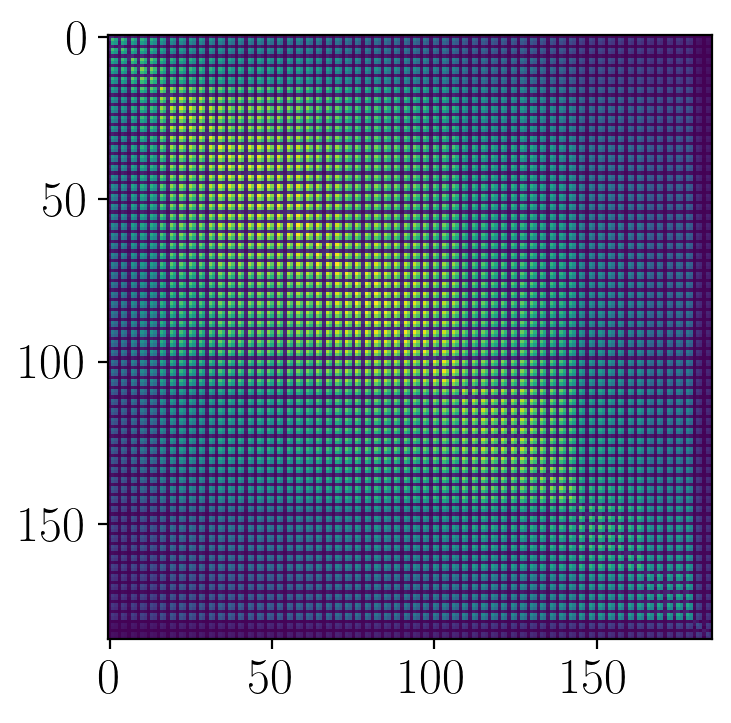

In [19]:
# fig = plt.figure(figsize=(6, 4), dpi=200)
# ax = fig.add_subplot(111)
# ax.imshow(abs(Q_dz_inv_perm))
# plt.show()

In [22]:
adr_map = adr - (B_red @ dz_map_est.flatten()).reshape((Nf, -1))
GIF_map = (C_GIF[:, None] * adr_map).sum(axis=0)
IF_map = (C_IF[:, None] * adr_map).sum(axis=0)
TEC_map = (C_TEC[:, None] * adr_map).sum(axis=0)

# adr_float = adr - (B @ dz_hat[-1].flatten()).reshape((Nf, -1))
adr_float = adr - (B_red @ dz_hat_red).reshape((Nf, -1))
GIF_float = (C_GIF[:, None] * adr_float).sum(axis=0)
IF_float = (C_IF[:, None] * adr_float).sum(axis=0)
TEC_float = (C_TEC[:, None] * adr_float).sum(axis=0)

GIF_raw = (C_GIF[:, None] * adr).sum(axis=0)
IF_raw = (C_IF[:, None] * adr).sum(axis=0)
TEC_raw = (C_TEC[:, None] * adr).sum(axis=0)

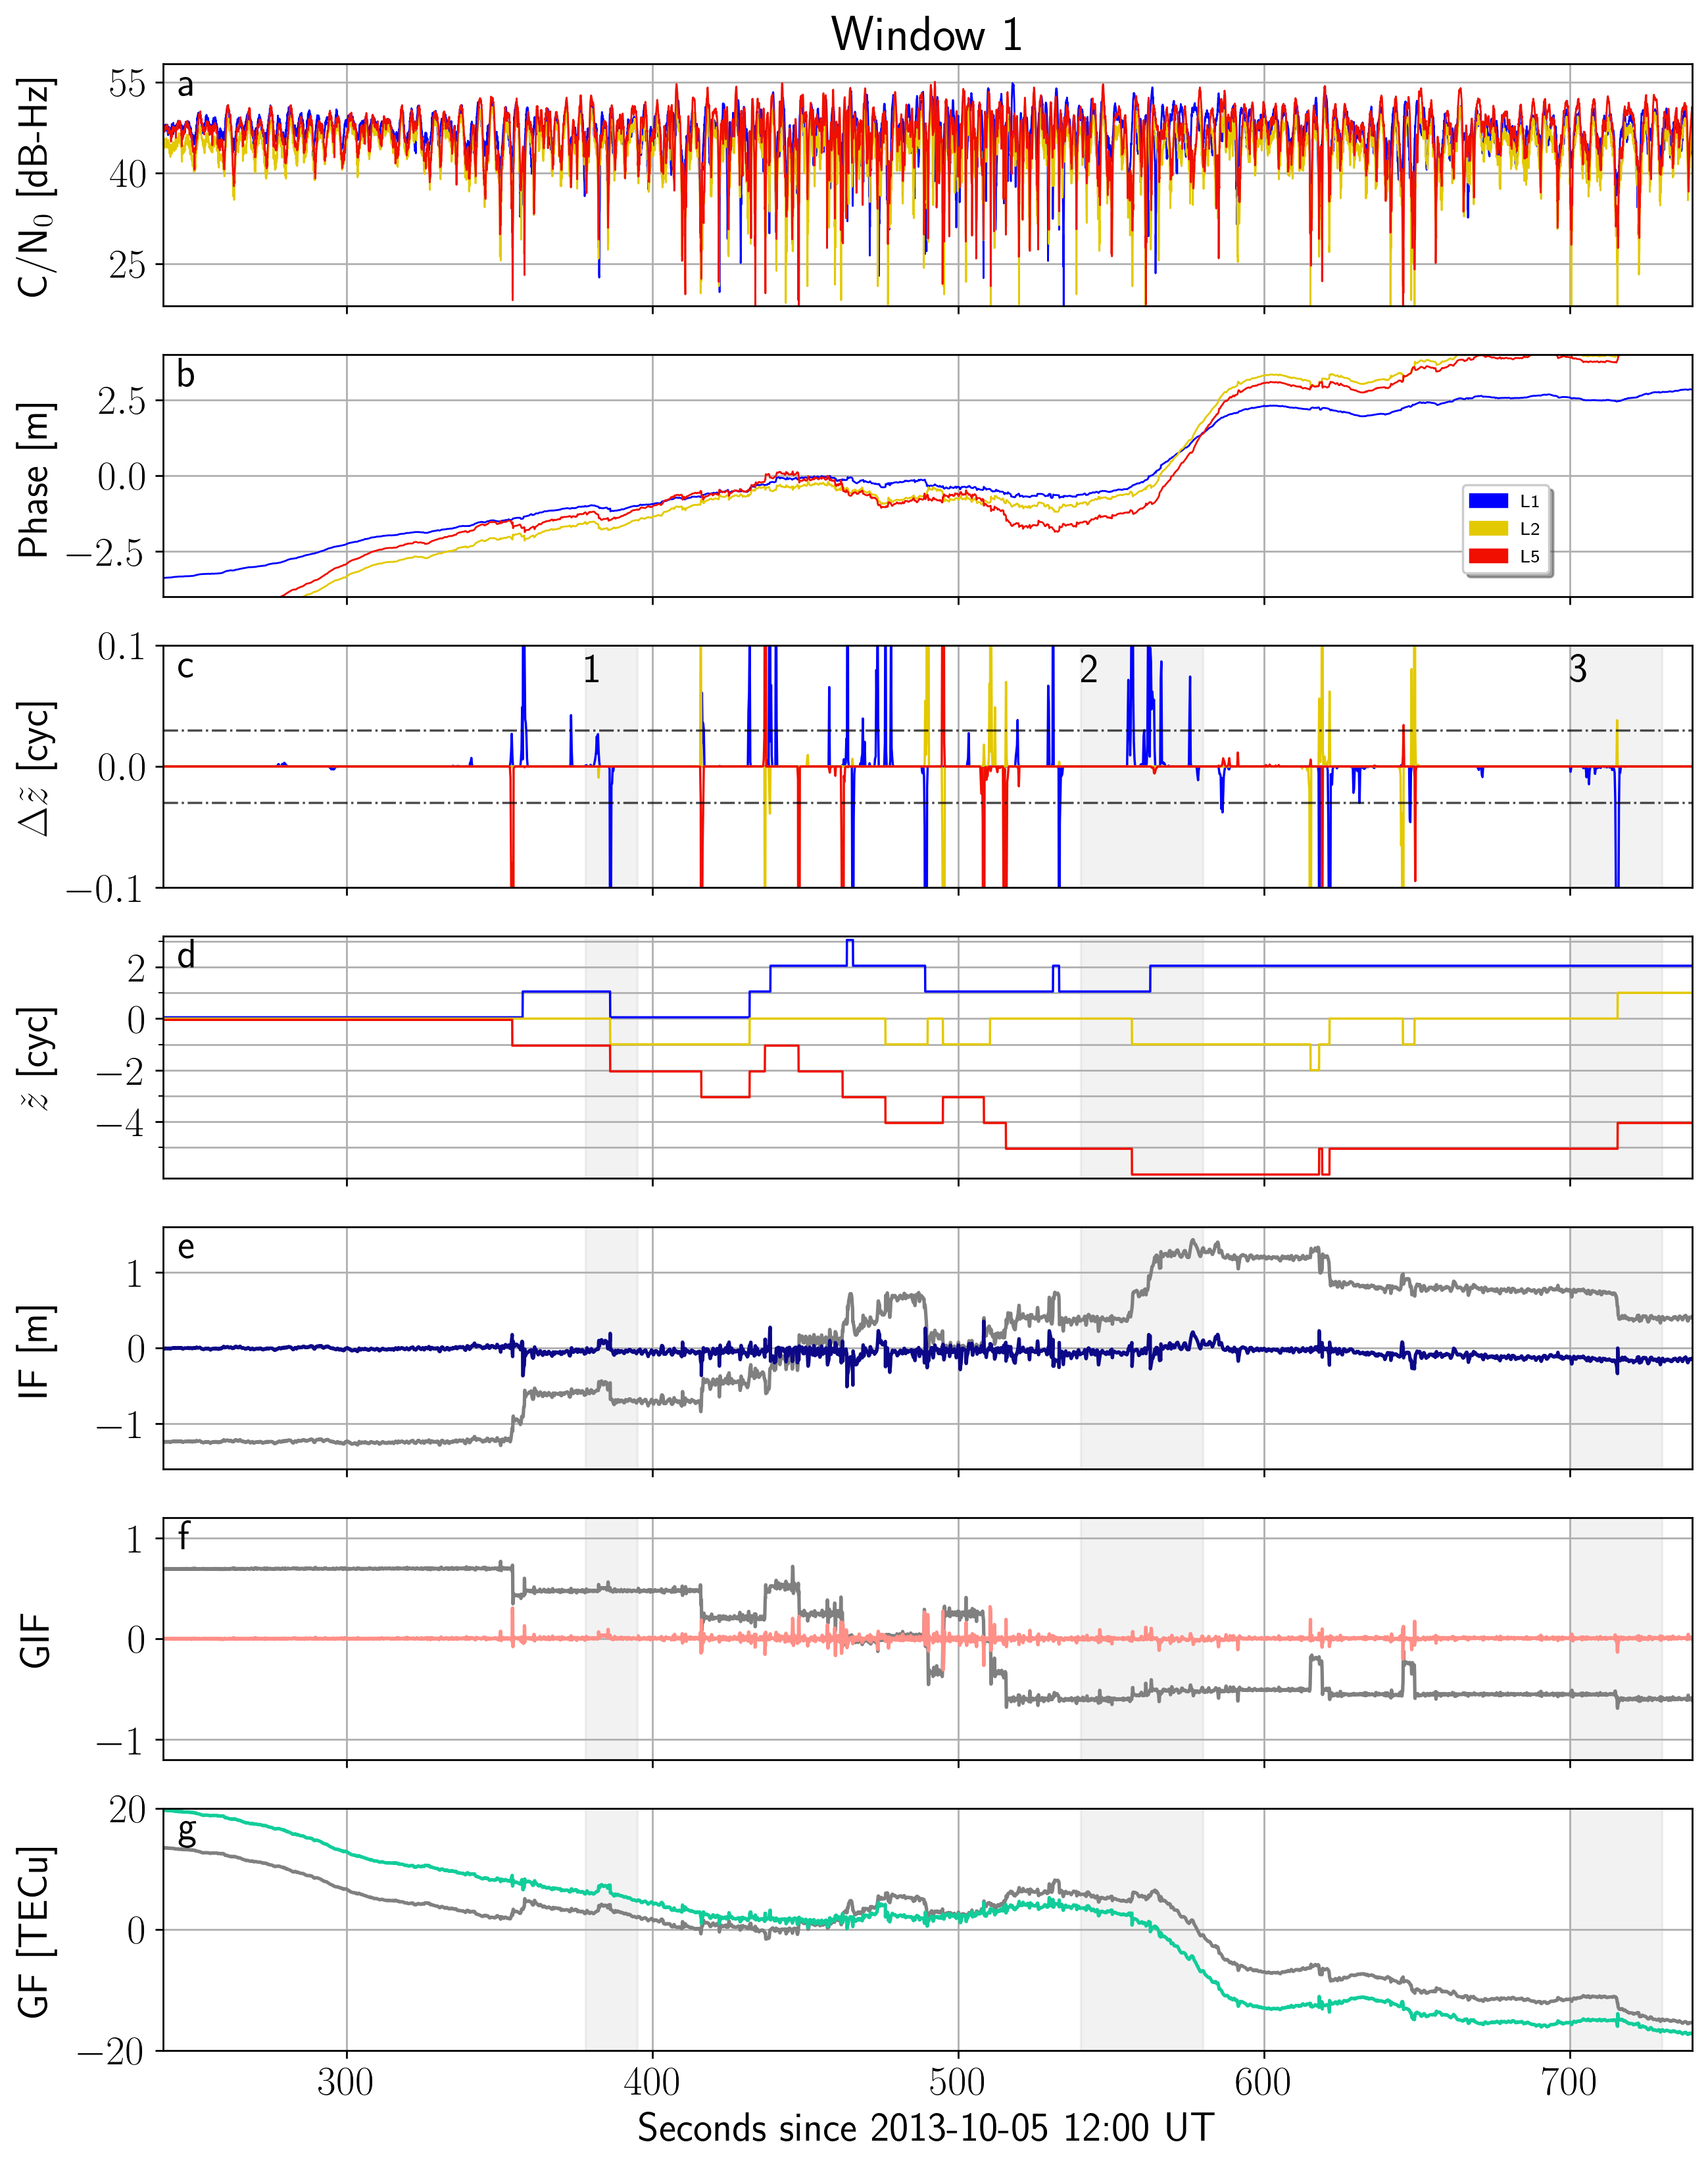

In [23]:
fig = plt.figure(figsize=(12, 16), dpi=250)
axes = [fig.add_subplot(7, 1, 1 + i) for i in range(7)]
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes

t_ref_dt = gpst2dt(start_of_day_gpst + time[0]).replace(minute=0, second=0)
t0_plot = dt2gpst(t_ref_dt) - start_of_day_gpst

for k, sig_id in zip(range(Nf), sig_ids):
    ax1.plot(time - t0_plot, cn0_dB[k, :], color=COLORS[sig_id], linewidth=.8)
    ax2.plot(time - t0_plot, adr[k, :] - numpy.mean(adr[k, :]), color=COLORS[sig_id], linewidth=.8)
    ax3.plot(time_z - t0_plot, dz_hat[-1, k, :], color=COLORS[sig_id], linewidth=1)
    ax4.plot(time - t0_plot, z_map_est[k, :] - (k - 1) * .05, color=COLORS[sig_id], linewidth=1)

ax5.plot(time - t0_plot, IF_raw - numpy.mean(IF_raw), color=(.5, .5, .5))
ax5.plot(time - t0_plot, IF_map - IF_map[0], color=COLORS['IF'])

ax6.plot(time - t0_plot, GIF_raw - numpy.mean(GIF_raw), color=(.5, .5, .5))
ax6.plot(time - t0_plot, GIF_map - GIF_map[0], color=COLORS['GIF'])

ax7.plot(time - t0_plot, TEC_raw - numpy.mean(TEC_raw), color=(.5, .5, .5))
ax7.plot(time - t0_plot, TEC_map - numpy.mean(TEC_map), color=COLORS['GF'])

detection_threshold = .03
ax3.plot(time[[0, -1]] - t0_plot, (-detection_threshold,)*2, color='k', linestyle='-.', linewidth=1, alpha=.7)
ax3.plot(time[[0, -1]] - t0_plot, (detection_threshold,)*2, color='k', linestyle='-.', linewidth=1, alpha=.7)

for ax in axes:
    ax.grid()
    ax.set_xlim(time[[0, -1]] - t0_plot)
ax1.set_ylim(18, 58)
ax1.set_yticks([25, 40, 55])
ax1.set_ylabel(r'$\text{C}/\text{N}_0$ [dB-Hz]')
ax2.set_ylim(-4, 4)
ax2.set_ylabel('Phase [m]')
ax3.set_ylim(-.1, .1)
ax3.set_ylabel(r'$\Delta\tilde{z}$ [cyc]')
ax4.set_yticks([--6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], minor=True)
ax4.set_yticks([-4, -2, 0, 2, 4, 6])
ax4.set_ylim(-6.2, 3.2)
# ax4.set_ylim(-3.2, 5.2)
ax4.grid(which='minor')
ax4.set_ylabel(r'$\check{z}$ [cyc]')
ax5.set_ylim(-1.6, 1.6)
ax5.set_ylabel('IF [m]')
ax6.set_ylim(-1.2, 1.2)
ax6.set_ylabel('GIF')
ax7.set_ylim(-20, 20)
# ax7.set_ylim(-10, 10)
ax7.set_ylabel('GF [TECu]')

regions = [
    ([43578, 43595], [2, 3, 4, 5, 6]),
    ([43740, 43780], [2, 3, 4, 5, 6]),
    ([43900, 43930], [2, 3, 4, 5, 6]),
]
for i, reg in enumerate(regions):
    window, panels = reg
    t0, t1 = window
    for j, p in enumerate(panels):
        ax = axes[p]
        ylim = ax.get_ylim()
        if j == 0:
            ax.text(t0 - t0_plot, ylim[1] - .03, '{0}'.format(i + 1))
        ax.fill_between(array([t0, t1]) - t0_plot, [ylim[0]] * 2, [ylim[1]] * 2, color=(.5,.5,.5), zorder=-1, alpha=.1)
        ax.set_ylim(ylim)


ax1.set_title('Window {0}'.format(window_label))

for i, ax in enumerate(axes):
    ax.text(.01, .87, 'abcdefgh'[i], transform=ax.transAxes)

handles = [plt.Rectangle((nan, nan), 1, 1, color=COLORS[sig_id]) for sig_id in sig_ids]
labels = sig_ids
ax2.legend(handles, labels, loc=(.85, .1), shadow=True, fontsize=8)

for ax in axes[:-1]:
    ax.set_xticklabels([])
axes[-1].set_xlabel('Seconds since {0}'.format(t_ref_dt.strftime('%Y-%m-%d %H:%M UT')))
fig.align_labels()

# TODO add detections
filename = 'real-data-window-{0}.svg'.format(window_label)
filepath = os.path.join(plot_dir, filename)
# plt.tight_layout()
# plt.savefig(filepath, bbox_inches='tight')
plt.show()

.

.

.

.

.

.

.